In [ ]:
from matplotlib import path as mpath

class OwnErrorMarker(mpath.Path):

    def __init__(self, *args, subtract_mean=True, **kwargs):
        super().__init__(*args, **kwargs)

        if subtract_mean:
            self.vertices = (self.vertices - self.vertices.mean(axis=0))
        self._vertices_orig = self.vertices
        self._scatter_kwargs = dict(facecolors='none',
                                    capstyle='round')

    def reset(self):
        self.vertices = self._vertices_orig

    def top(self, scale=1):
        self.vertices = self._vertices_orig * [scale, scale]
        return self

    def bot(self, scale=1):
        self.vertices = self._vertices_orig * [scale, -scale]
        return self

    def update_scatter_kwargs(self, **scatter_kwargs):
        self._scatter_kwargs.update(**scatter_kwargs)

    def get_scatter_kwargs(self):
        return self._scatter_kwargs

    def add_to_legend(self, ax, label, offset=3, ms=100,
                      rotate=True, scale=1, color='k',
                      do_not_use_label=False):
        loc_vertices = np.concatenate(
            [(self._vertices_orig + [0, offset]) * [scale, scale],
             (self._vertices_orig + [0, offset]) * [scale, -scale]])

        loc_codes = np.concatenate([self.codes, self.codes])

        if rotate:
            loc_vertices = loc_vertices @ [[0, 1], [1, 0]]

        return ax.scatter(np.nan, np.nan, s=ms, edgecolor=color,
                          marker=mpath.Path(loc_vertices, loc_codes),
                          label=None if do_not_use_label else label,
                          **self._scatter_kwargs)


ERROR_MARKERS = {
    "fancy": OwnErrorMarker(
        [[-2, -1], [-1, 1], [1, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "rectangle": OwnErrorMarker(
        [[-3, -1], [-3, 1], [3, 1], [3, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO, mpath.Path.LINETO]),
    "triangle": OwnErrorMarker(
        [[-2, -1], [0, 1], [2, -1]],
        [mpath.Path.MOVETO, mpath.Path.LINETO,
         mpath.Path.LINETO]),
}

# plotting stuff
def plot_error_markers(ax, x, y, ydown, yup=None, markerstyle='rectangle',
                       scale=1, color='k', **scatter_kwargs):
    #from kapu.extension.markers import ERROR_MARKERS

    om = ERROR_MARKERS[markerstyle]

    scatter_kwargs.update(**om.get_scatter_kwargs())

    if yup is None:
        yup = ydown

    sca1 = ax.scatter(x, y + yup, edgecolors=color,
                      marker=om.top(scale), **scatter_kwargs)
    sca2 = ax.scatter(x, y - ydown, edgecolors=color,
                      marker=om.bot(scale), **scatter_kwargs)

    return (sca1, sca2), om

# legend stuff
def add_errormarker_labels(ax, markers, labels, colors=None,
                           new_legend=False, rotate=True, legend_kwargs={}):

    if colors is None:
        colors = ['k'] * len(markers)

    pcs = []
    for marker, label, color in zip(markers, labels, colors):
        marker = ERROR_MARKERS[marker]
        path_collection = marker.add_to_legend(ax, label, rotate=rotate, color=color,
do_not_use_label=new_legend)
        pcs.append(path_collection)

    if new_legend:
        legend = ax.legend(pcs, labels, **legend_kwargs)
        return legend
    else:
        pass

In [ ]:
from utils.binaries import *
from utils.plotting import *

fig, ax = plt.subplots()

dy = np.abs(np.random.normal(scale=5, size=50))
x = np.linspace(0, 10, 50)
y = x + dy

ax.errorbar(x, y, 0.5*dy, fmt='o', label='hallo')
plot_error_markers(ax, x, y, dy, s=20)


ax.legend()

In [ ]:
from utils.auger.sd import sim

In [ ]:
test_sim = sim.Simulation('icrc2025-test7-SdMdInfillSimRec',
                        offline='icrc2025-test7',
                        src='/cr/users/filip/Projects/PhotonSimulations/discrimination/icrc2025-test5-SdMdInfillSimRec',
                        request_memory = "6G",
                        primary="proton",
                        energy="18_18.5",
                        model="epos_lhc",
                        seed = 5,
                        queue = 5000,
                        verbose=False)

In [ ]:
is_sim_file = (lambda s: s.startswith("DAT")
                           and not s.endswith(".long")
                           and not s.endswith(".lst")
                           and not s.endswith(".gz"))

target_path = '/lsdf/auger/corsika/prague/EPOS_LHC/photon/16_16.5'
print(len(list(filter(is_sim_file, os.listdir(target_path)))))

In [ ]:
from pathlib import Path
from utils.binaries import *
from utils.plotting import *

from tqdm import tqdm
from scipy.signal import find_peaks
from utils.auger.fd import PixelPlot
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

from astropy.timeseries import LombScargle
import ruptures as rpt

from functools import cache

class Periodogram(LombScargle):
    
    def __init__(self, x, y):
        self.min_frequency = 1/np.max(x)

        super().__init__(x, y)

    @cache
    def power_spectral_density(self):
        freq, power = self.autopower(
                minimum_frequency = 1/np.max(self.t),
                maximum_frequency = 1,
                samples_per_peak = 10,
                normalization = "psd"
        )

        mask = np.argsort(period := 1/freq)
        return period[mask], power[mask] / 1e3
    

    def get_peaks(self, n_peaks, **peak_finder_kwargs) -> list:
        _, power = self.power_spectral_density()
        return find_peaks(power, **peak_finder_kwargs)[0][:-n_peaks-1:-1]


    def get_model(self, peaks):
        
        period, _ = self.power_spectral_density()

        def fct(x):
            y_model = np.zeros_like(x)
            
            for peak in peaks:
                y_model += self.model(x, 1/period[peak]) - self.offset()
            y_model += self.offset()

            return y_model

        return fct


    def show(self, ax=None):

        if ax is None:
            ax = plt.gca()

        ax.plot(*self.power_spectral_density(), marker="none")
        ax.set_xlabel('Period / $\mathrm{day}$')
        ax.set_ylabel(r"PSD / $\frac{\mathrm{ADC}^2}{\mathrm{mHz}}$")
        ax.set_xscale("log")        


class NSB():

    BASE = Path(f"/cr/tempdata01/filip/nsb_data/")

    def __init__(self, site: str, tel: int):

        IGNORE_SAMPLES_BELOW = 40
        df, n = None, 0

        self.source_dir = self.BASE / f"{site}{tel}"
        for file in self.source_dir.iterdir():
            print(f"loading {file}...", end='\r')
            
            df_part = tools.pickle_load(file)
            df_part = df_part[df_part["Samples"] >= IGNORE_SAMPLES_BELOW]
            df_part = df_part.dropna()

            if df is None:
                df = df_part
            else:
                df = pd.concat([df, df_part])

            n += 1

        df["Date"] = pd.to_datetime(df["Date"])
        df.rename(columns={"Date": "datetime"}, inplace=True)
        df["days_since_start"] = xt = df["datetime"].apply(lambda x: x.timestamp())
        df["days_since_start"] = (xt - xt.min()) / (24 * 3600)

        if site == "Coihueco" and tel == 4:
            df.rename(columns={"Baseline": "median_Baseline"})

        df["night_sky_background"] = (df["median_Variance"] - df["median_Baseline"]) / 1e3

        print(f"\n{n} files ({n/12:.1f} yrs) loaded for {site} #{tel}")

        self.df = df
        self.tel = tel
        self.site = site


    def plot_pixel(self, pixel, ax=None, 
                   show_mean=False, 
                   show_drift=False, 
                   show_jumps=False) -> None:

        if ax is None:
            ax = plt.gca()

        opacity = 0.1 if show_mean or show_drift else 1
        df_pixel = self.get_pixel(pixel)

        x = df_pixel["datetime"]
        xt = df_pixel["days_since_start"]
        y = df_pixel["night_sky_background"]
        
        ax.scatter(x, y, 
                    alpha=opacity, 
                    ec='none')

        if show_mean:
            ax.plot(*tools.running_mean(x, y, 7 * 30), marker='none',
                    label="1-month rolling mean")

        if show_drift:
            popt, pcov = np.polyfit(xt, y, deg=1, cov=True)
            f = np.poly1d(popt)

            drift_params = uncertainties.correlated_values(popt, pcov)
            value = drift_params[0]/f(0) * 36500
            value = f"{value.nominal_value:.2f}\pm{value.std_dev:.2f}"

            ax.plot(x, f(xt), label=f"${value}$ %/yr", marker='none')

        if show_jumps:
            
            algo = rpt.Binseg(model="l1").fit(y.values)
            result = algo.predict(n_bkps=1)

            ax.axvline(x.values[result[0]], linestyle="--", lw=0.3)

        ax.set_ylabel("$\sigma^2_\mathrm{NSB}$ / ADC$^2$")
        ax.legend(title=f'{self.site} {self.tel} $-$ #{pixel}')
        plot.apply_datetime_format(ax)


    @cache
    def get_pixel(self, pixel) -> pd.DataFrame:
        return self.df[self.df["PixelId"] == pixel]
   

    def camera_drift(self, show=True) -> np.ndarray:

        percent_drift_per_year = np.zeros(440)
        for pixel in tqdm(range(1, 441)):

            df_pixel = self.get_pixel(pixel)
            xt = df_pixel["days_since_start"].values
            y = df_pixel["night_sky_background"].values

            popt = np.polyfit(xt, y, deg=1)
            f = np.poly1d(popt)
            drift = popt[0]/f(0) * 36500

            percent_drift_per_year[pixel-1] = drift

        if show:

            def get_row(row):
                return percent_drift_per_year[row::22]

            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, 
                                            width_ratios=[0.2, 0.8])

            data_max = np.nanmax(np.abs(percent_drift_per_year))
            vmin, vmax = np.floor(-data_max), np.ceil(data_max)

            ax2 = PixelPlot(percent_drift_per_year, vmin=vmin, 
                            vmax=vmax,cmap=plt.cm.coolwarm, ax=ax2,
                            annotate=True)

            ticks = np.arange(vmin, vmax + 0.1, 1)
            norm = BoundaryNorm(np.linspace(vmin, vmax, endpoint=True), plt.cm.plasma.N)
            cbar = plt.gcf().colorbar(ScalarMappable(norm=norm, cmap=plt.cm.coolwarm), 
                                        shrink=0.9, ax=ax2, location='right', 
                                        label='Pixel drift / percent per yr')

            cbar.set_ticks(ticks=ticks, labels=[f"${x:+.0f}$" for x in ticks])
            ax2.set_title(f"{self.site} - Mirror {self.tel}")

            centerRow = 35 / 3.0
            elevation, rows = [], []
            for row in range(22):

                elevation.append((row - centerRow + 1) * 1.5 * np.sqrt(3) / 2)
                rows.append(get_row(row))

            ax1.boxplot(rows, positions=elevation, vert=False,
                        showfliers=False, notch=True, widths=0.8)
            ax1.set_yticks([])
            ax1.axvline(0, ls='--', c='k', lw=0.5)
        
            plt.subplots_adjust(wspace=0)

        return percent_drift_per_year
    

    def get_pixel_periodogramm(self, pixel, show=False) -> Periodogram:
        pixel_df = self.get_pixel(pixel)
        periodogram = Periodogram(pixel_df["days_since_start"],
                                  pixel_df["night_sky_background"])

        if show:
            fig, (ax1, ax2) = plt.subplots(2, 1)
            self.plot_pixel(pixel, ax1, show_mean=True)
            periodogram.show(ax2)

        return periodogram
    

    def show_pixel_periodogram(self, pixel, **peak_kwargs) -> (plt.Axes):

        fig, (ax1, ax2) = plt.subplots(2, 1)

        pixel_df = self.get_pixel(pixel)

        self.plot_pixel(pixel, ax1, show_mean=True)
        periodogram = self.get_pixel_periodogramm(pixel)
        period, _ = periodogram.power_spectral_density()
        periodogram.show(ax2)

        n_peaks = peak_kwargs.pop("n_peaks", 1)
        for peak in (result := periodogram.get_peaks(n_peaks, **peak_kwargs)):
             ax2.axvline(period[peak], c='orange', 
                         ls='--', lw=0.5, zorder=0)
    
        model = periodogram.get_model(result)
        ax1.plot(pixel_df["datetime"], model(pixel_df["days_since_start"]), marker="none")

        return model

In [151]:
test = NSB("LosMorados", 2)

loading /cr/tempdata01/filip/nsb_data/LosMorados2/nsb_2012-05-01_to_2012-06-01.pkl...
29 files (2.4 yrs) loaded for LosMorados #2


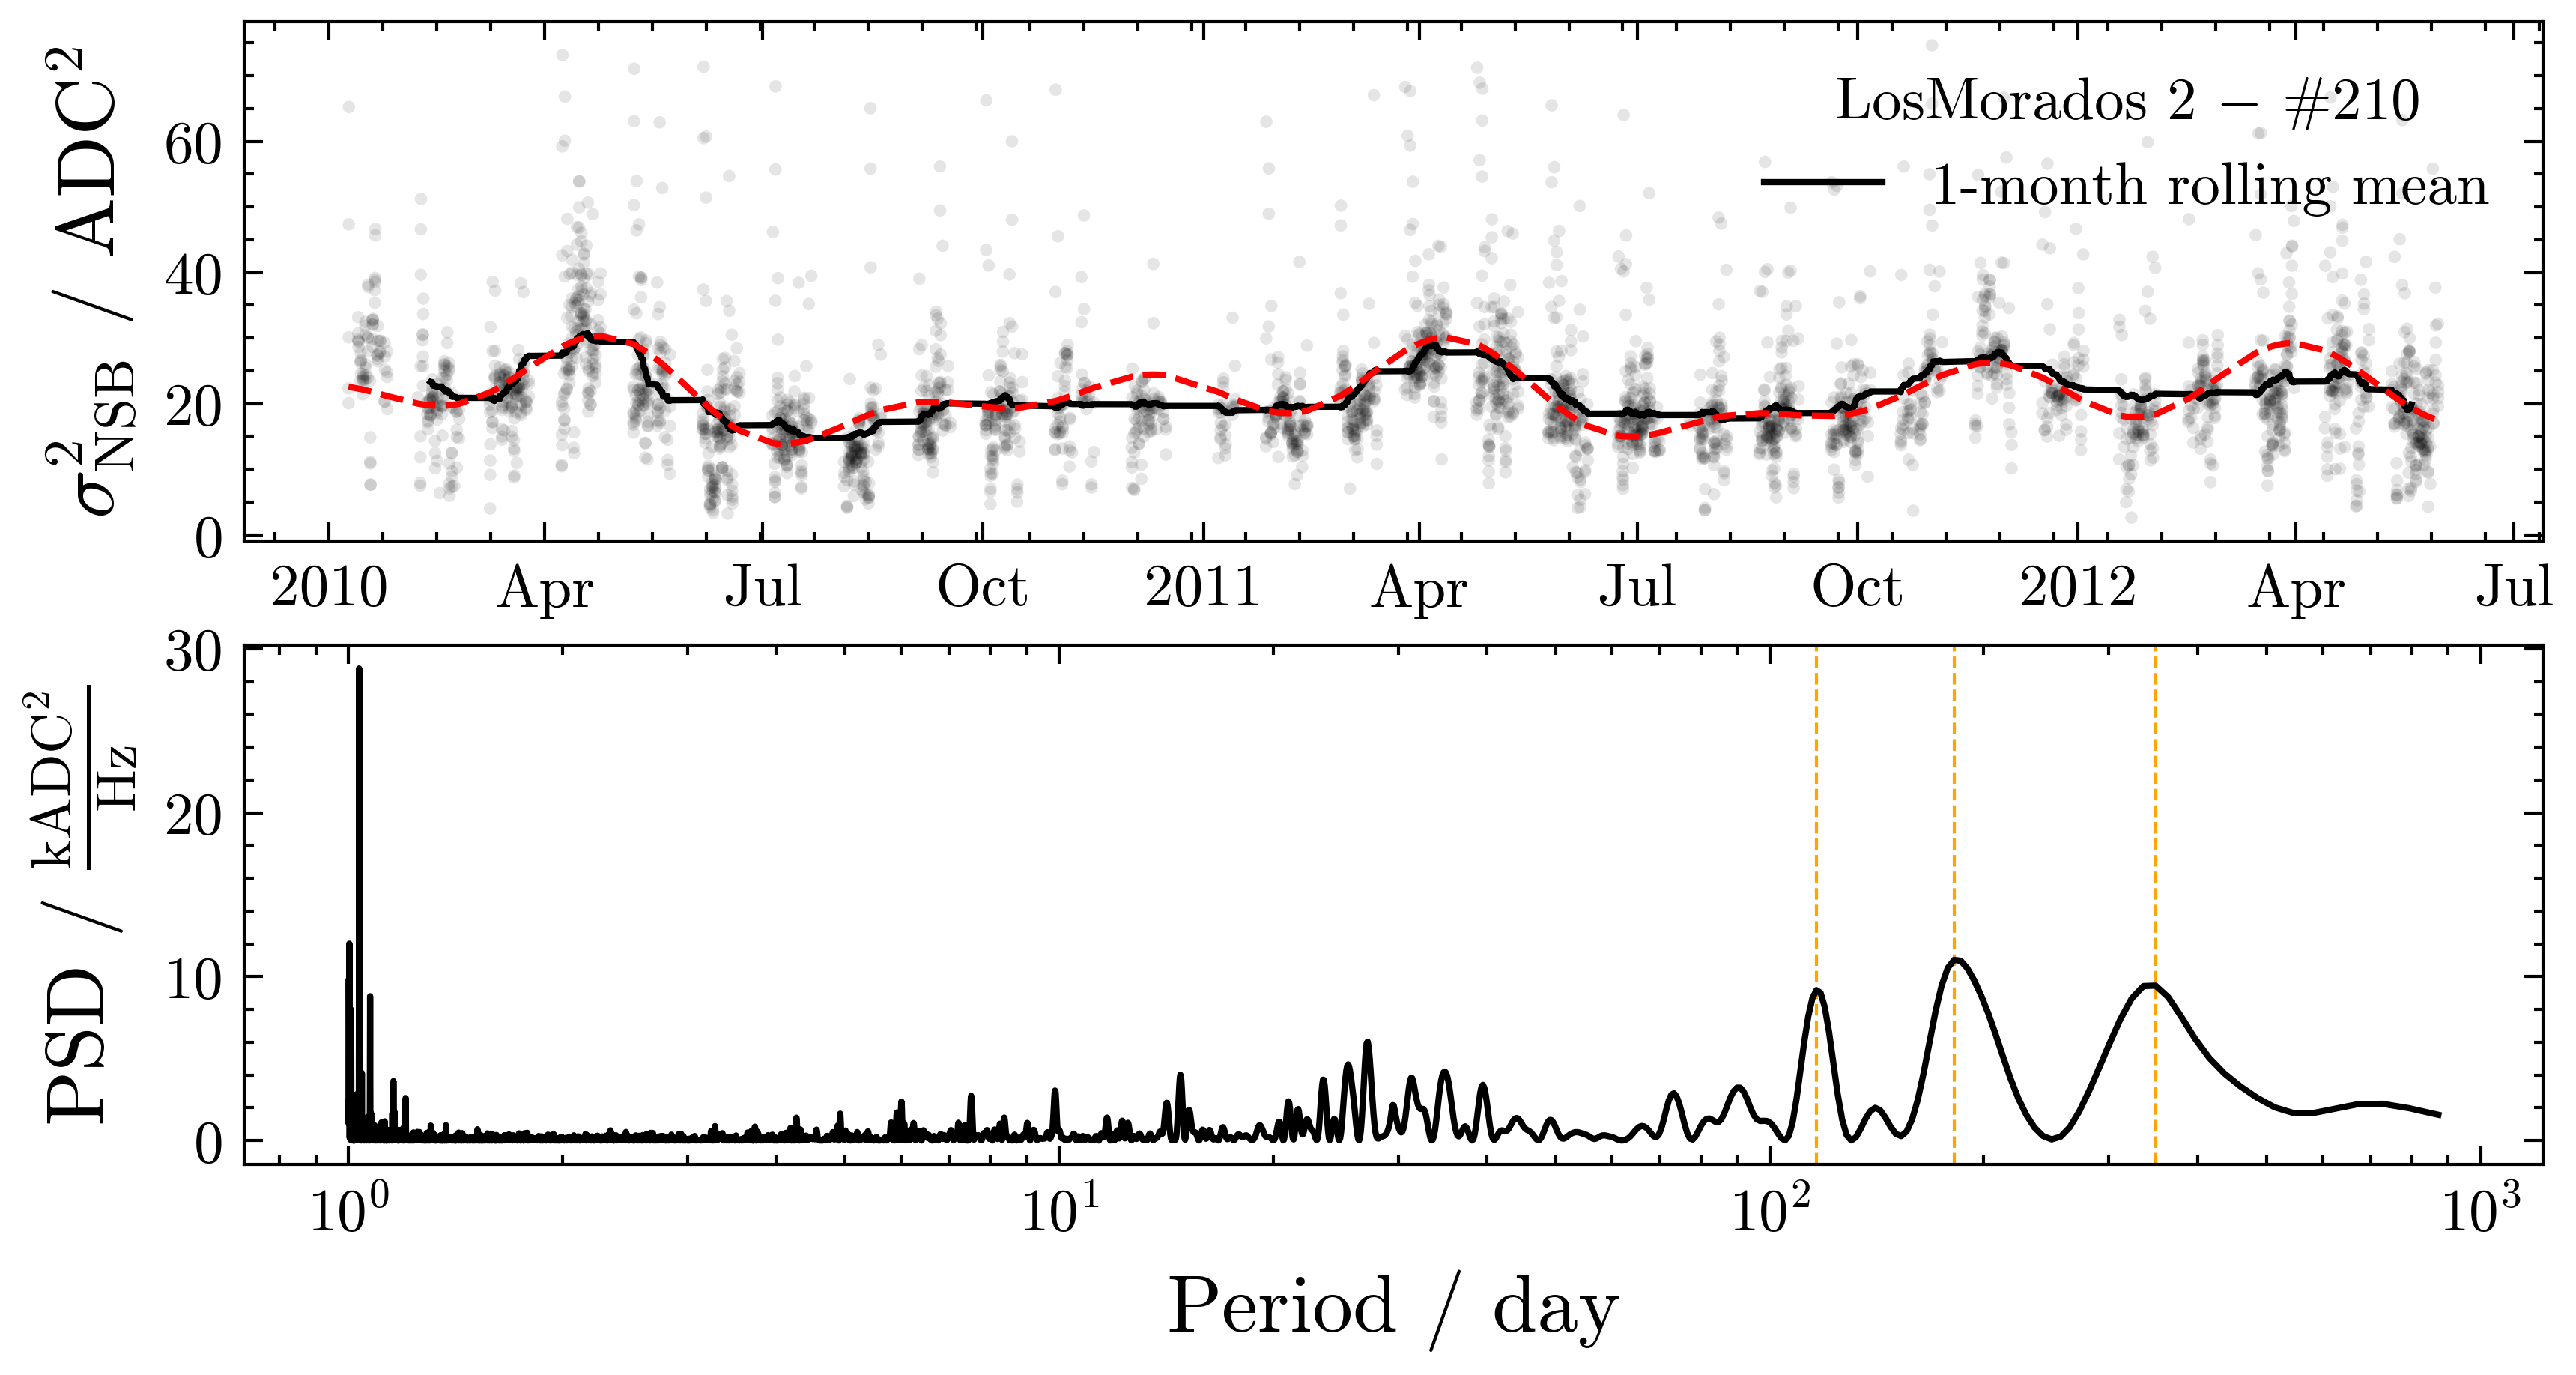

In [158]:
model = test.show_pixel_periodogram(210, n_peaks=3, height=3)

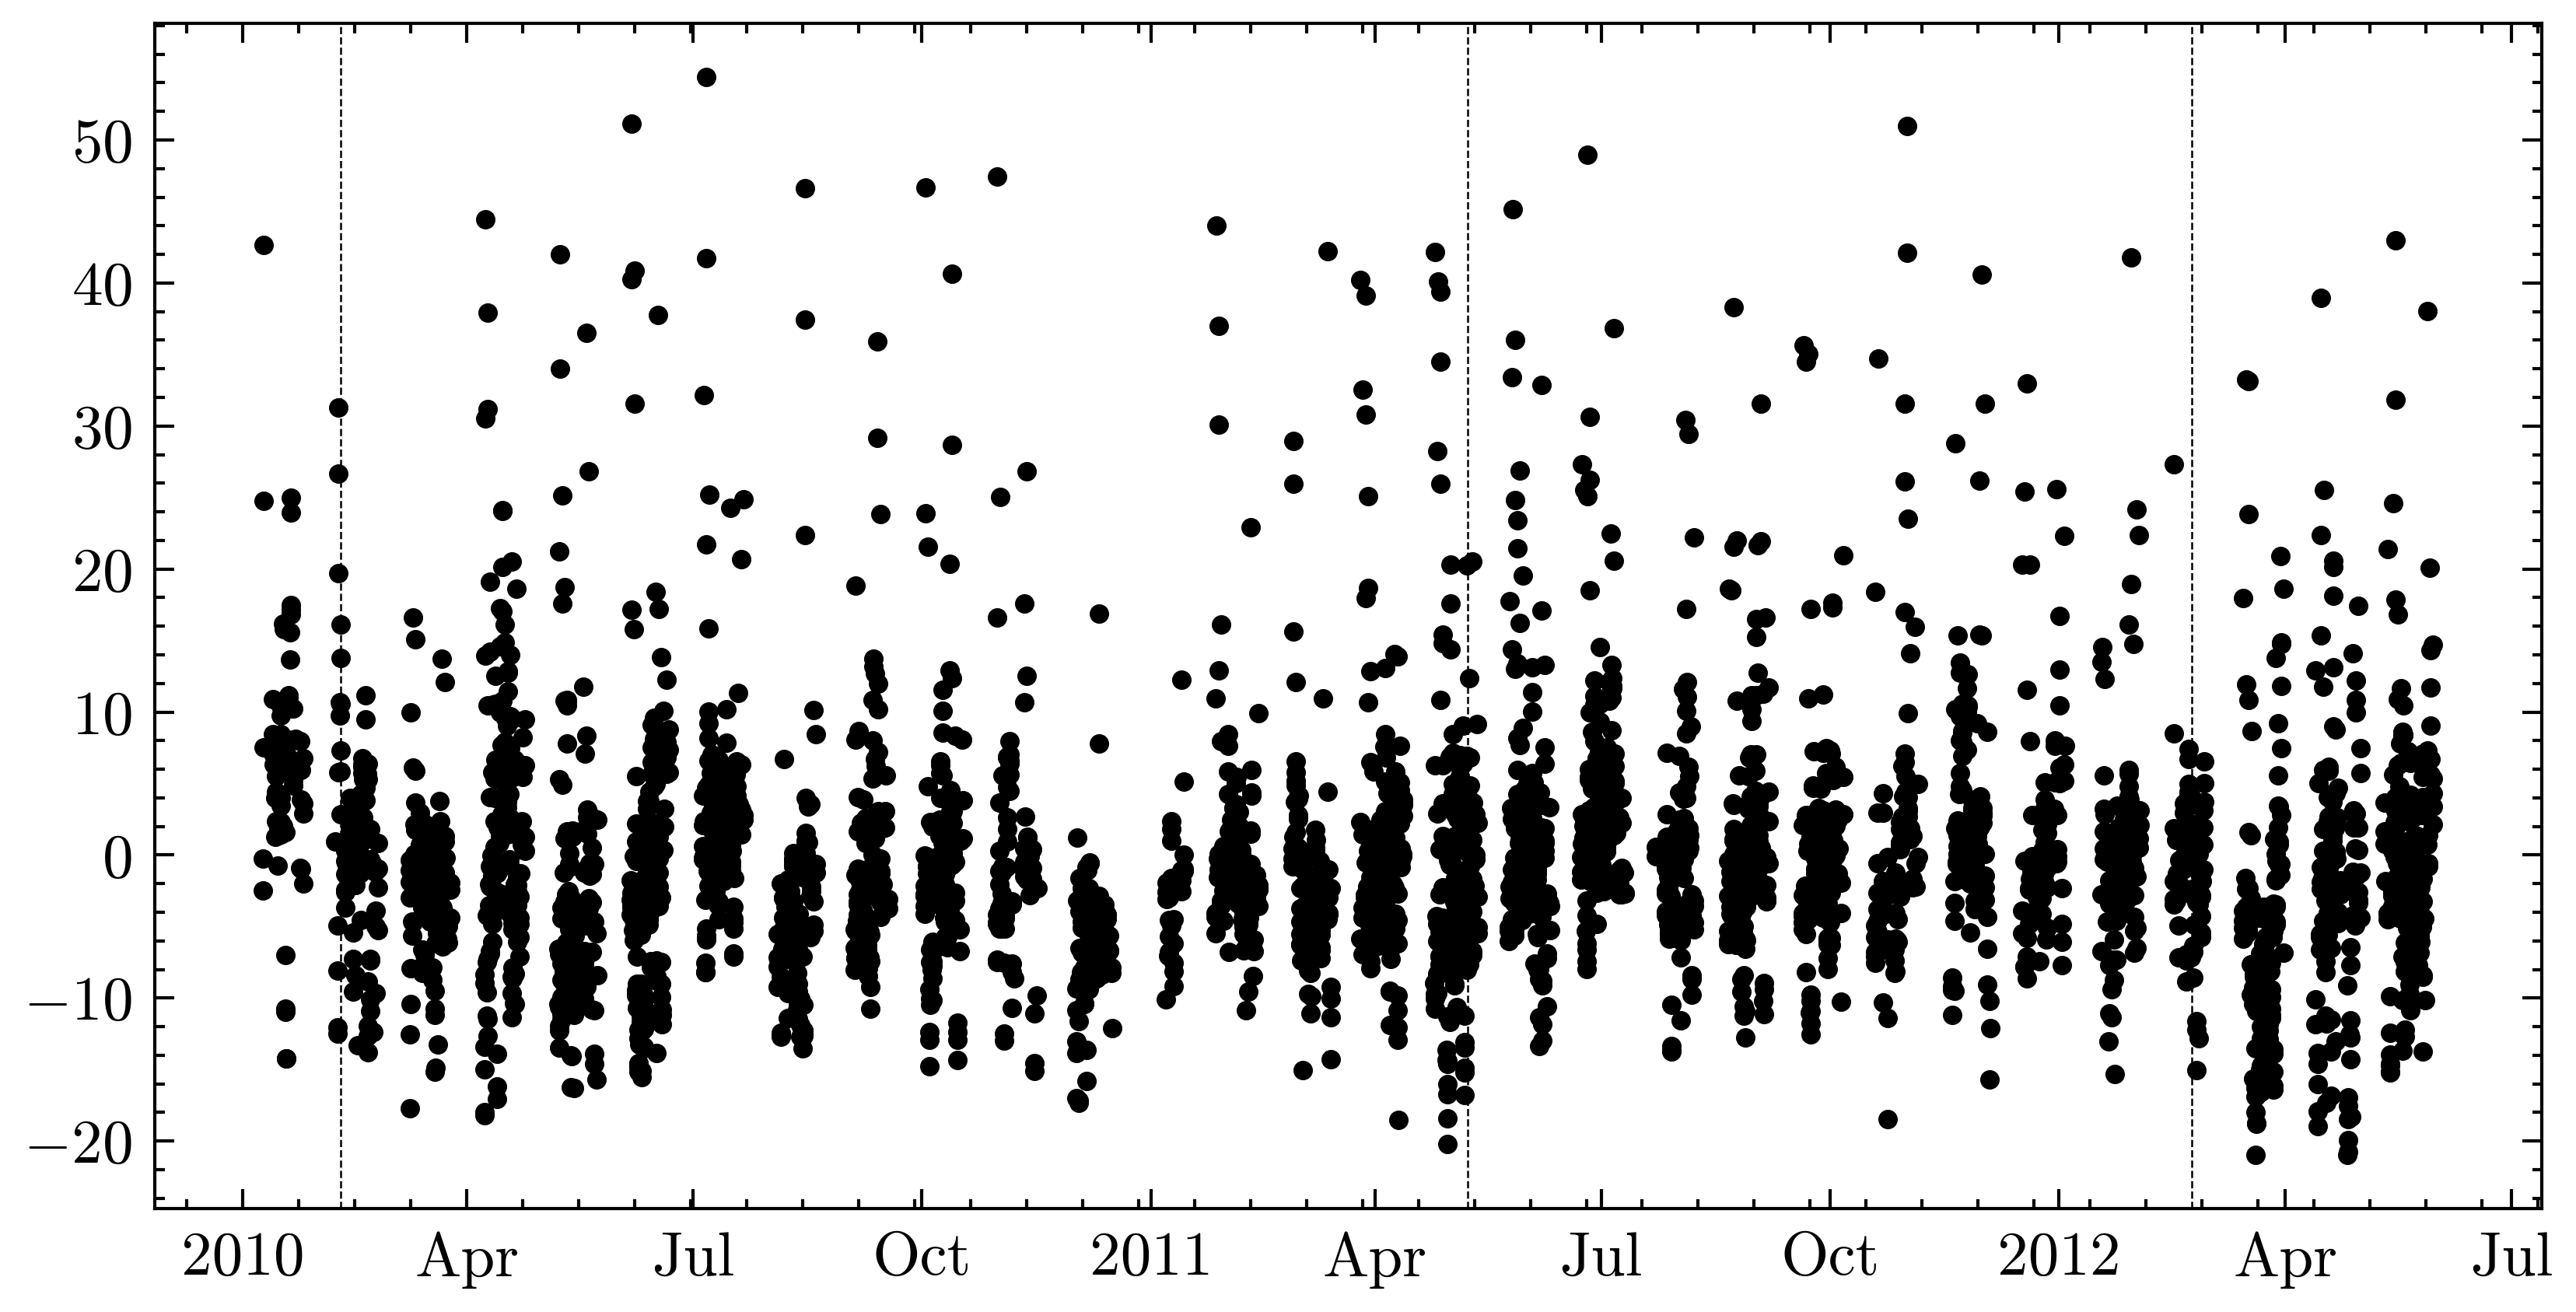

In [166]:
df_pixel = test.get_pixel(210)

x = df_pixel["datetime"]
y = df_pixel["night_sky_background"] - model(df_pixel["days_since_start"])

algo = rpt.Binseg(model="l1").fit(y.values)
result = algo.predict(n_bkps=3)

for res in result[:-1]:
    plt.axvline(x.values[res], linestyle="--", lw=0.3)

plt.scatter(x, y)

plot.apply_datetime_format(plt.gca())